In [ ]:
!pip install tensorflow_addons
!pip install pytorch-tabnet
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
import torch
import tensorflow as tf
from tensorflow import keras
from typing import Optional, Union, Tuple
from pytorch_tabnet.tab_model import TabNetRegressor
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import tensorflow.python
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import sklearn 
import sklearn.linear_model 
import matplotlib 
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
sns.set(rc={'figure.figsize':(11.7,8.27)})

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

     |████████████████████████████████| 1.1 MB 8.2 MB/s 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3809417134433844876
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15371862016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8470337856792644686
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [ ]:
#mount drive
from google.colab import drive
from google.colab import files
drive.mount("/content/drive/")
#read file
df = pd.read_csv('/content/drive/MyDrive/Thesis/df_cleaned.csv',sep=",",header=0,index_col=False)



Mounted at /content/drive/


In [ ]:
df.shape

(1061219, 45)

In [ ]:
#train-valid-test
train = df
target = 'total_score'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.98, .01, .01], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [ ]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

categorical_indxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [ ]:
X_train = train.loc[train_indices,features].values
y_train = train.loc[train_indices,target].values.reshape(-1, 1)

X_valid = train.loc[valid_indices,features].values
y_valid = train.loc[valid_indices,target].values.reshape(-1, 1)

X_test = train.loc[test_indices,features].values
y_test = train.loc[test_indices,target].values.reshape(-1, 1)

In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
tabnet_params = dict(
   
    n_d = 16,
    n_a = 16,
    n_steps = 9,
    gamma = 1.2,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0.00001,
    cat_idxs= categorical_indxs,
    cat_dims = cat_dims,
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2)),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type = "sparsemax",
    seed = 42,
    verbose = 1,
    cat_emb_dim=1   
)
reg_1 = TabNetRegressor(**tabnet_params)

Device used : cuda


In [ ]:
reg_1.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=200,
    patience=10,
    batch_size=	8192, virtual_batch_size=128,
    num_workers=2,
    drop_last=False
)

epoch 0  | loss: 16297.67009| train_mse: 2577.43212| valid_mse: 2538.4985|  0:01:54s
epoch 1  | loss: 1908.68609| train_mse: 1915.53253| valid_mse: 1925.52622|  0:03:50s
epoch 2  | loss: 1795.97473| train_mse: 1746.30241| valid_mse: 1730.93605|  0:05:46s
epoch 3  | loss: 1755.80162| train_mse: 1777.46821| valid_mse: 1773.1587|  0:07:43s
epoch 4  | loss: 1734.80574| train_mse: 1726.23686| valid_mse: 1716.70528|  0:09:39s
epoch 5  | loss: 1706.17876| train_mse: 1656.53719| valid_mse: 1637.4091|  0:11:34s
epoch 6  | loss: 1640.28452| train_mse: 1601.2384| valid_mse: 1585.60777|  0:13:30s
epoch 7  | loss: 1574.4259| train_mse: 1558.71949| valid_mse: 1545.7647|  0:15:27s
epoch 8  | loss: 1497.50503| train_mse: 1487.94849| valid_mse: 1475.7407|  0:17:23s
epoch 9  | loss: 1463.47758| train_mse: 1479.9442| valid_mse: 1475.14038|  0:19:20s
epoch 10 | loss: 1450.00355| train_mse: 1443.01129| valid_mse: 1438.29853|  0:21:16s
epoch 11 | loss: 1441.49993| train_mse: 1491.09347| valid_mse: 1489.1294

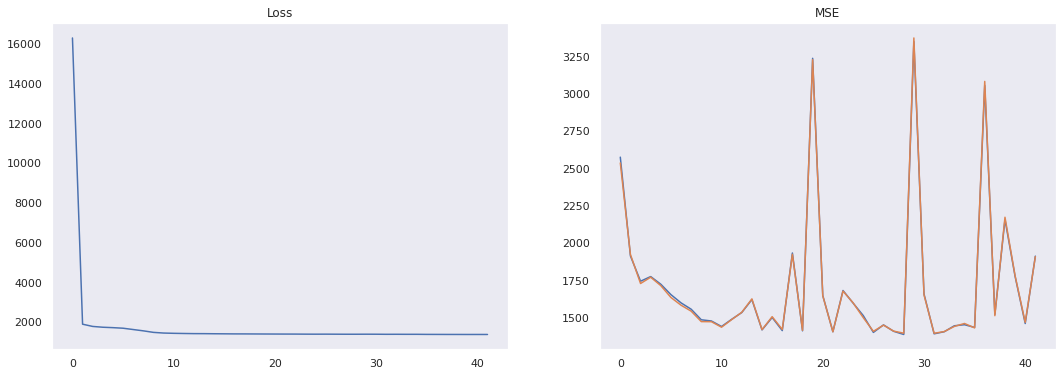

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=[18, 6])
plt.subplot(1, 2, 1)
plt.plot(reg_1.history['loss'])
plt.title('Loss')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(reg_1.history['train_mse'])
plt.plot(reg_1.history['valid_mse'])
plt.title('MSE')
plt.grid()
plt.savefig("TabNet_performance.png", dpi=100)
plt.show()
files.download("TabNet_performance.png")

In [ ]:
preds = reg_1.predict(X_test)
MSE = np.square(np.subtract(preds,y_test)).mean() 

print(f"BEST VALID SCORE FOR {'ICFES_Saber_11'} : {reg_1.best_cost}")
print(f"FINAL TEST SCORE FOR {'ICFES_Saber_11'} : {MSE}")

BEST VALID SCORE FOR ICFES_Saber_11 : 1397.6698414066454
FINAL TEST SCORE FOR ICFES_Saber_11 : 1356.1957550500958


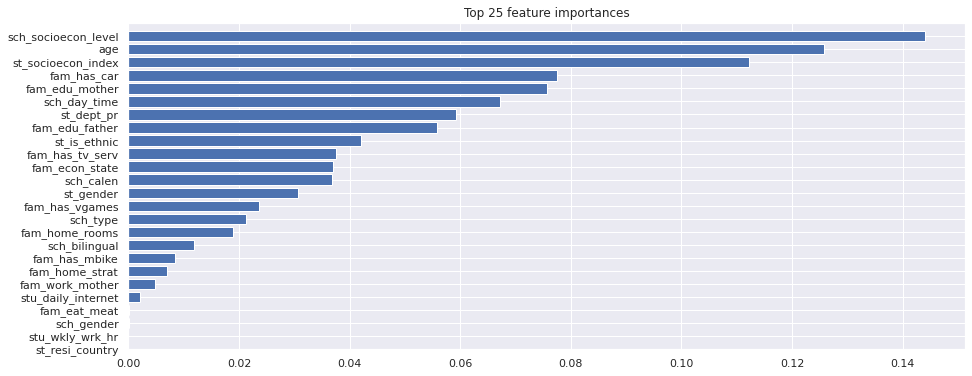

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
feat_importances = reg_1.feature_importances_
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(15, 6))
plt.title("Top 25 feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],color="b", align="center")
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
# all features
plt.ylim([-1, len(feat_importances)])
# Top 25 features
plt.ylim([len(feat_importances)-25, len(feat_importances)])
plt.savefig("Feat_importance_general.png", dpi=100)
plt.show()
files.download("Feat_importance_general.png")